In [1]:
%matplotlib inline
import math
import pandas as pd
from tsmom_model import *
import numpy as np
import statsmodels.tsa.vector_ar.var_model as VAR
from datetime import datetime
token="Us3wFmXGgAj_1cUtHAAR"

import pylab
sns.set(font_scale=3)
pylab.rcParams['figure.figsize'] = (24, 18)

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated since IPython 4.0.You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


# Load data

In [2]:
cleansed=load_amihud_markets_price()

tsmom_model.py:160: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  data=pd.read_csv('./Price.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='last')
tsmom_model.py:162: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  qd=pd.read_csv('./liquid_contracts.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='last')


# Amihud methodology

Amihud (2002) developed the illiquidity measure expressed by:

$$ Amihud = \frac{|r_t|}{\text{volume}_t} $$

where $r_t$ is the return on day $t$ and $Volume_t$ is the dollar volume on day $t$. 

The benefit of taking the daily return is to weight the move by change of price and the volume.


In [3]:
amihud=calculate_amihud_liquidity(cleansed)[:'2016'] 

tsmom_model.py:43: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  data=pd.read_csv('./Volume.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='mean')
tsmom_model.py:45: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  v=pd.read_csv('./volume_data.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='sum')
tsmom_model.py:47: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(min_periods=100,window=250,center=False).mean()
  volume=pd.rolling_mean(v,250,min_periods=100).resample(rule='d',how='mean')[:'2016']
tsmom_model.py:47: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  volume=pd.rolling_mean(v,250,min_periods=100).resample(rule='d',how='mean')[:'2016']
tsmom_model.py:50: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future ve

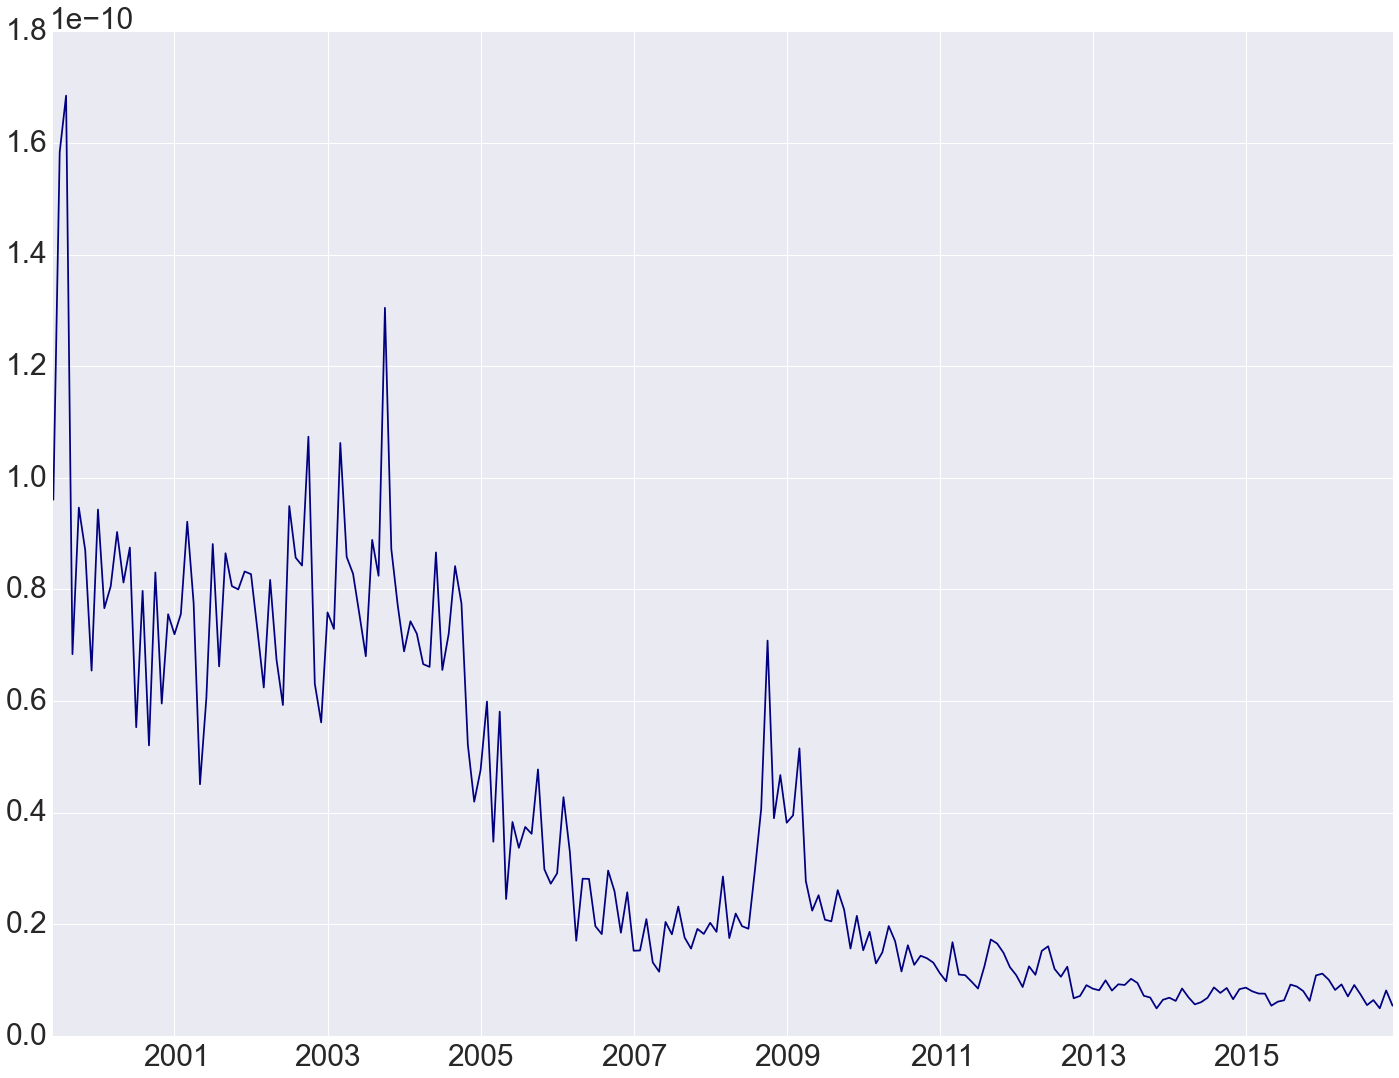

In [26]:
sns.set(font_scale=3)
pylab.rcParams['figure.figsize'] = (24, 18)
amihud.median(axis=1).dropna().plot(colormap='jet')

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  """Entry point for launching an IPython kernel.


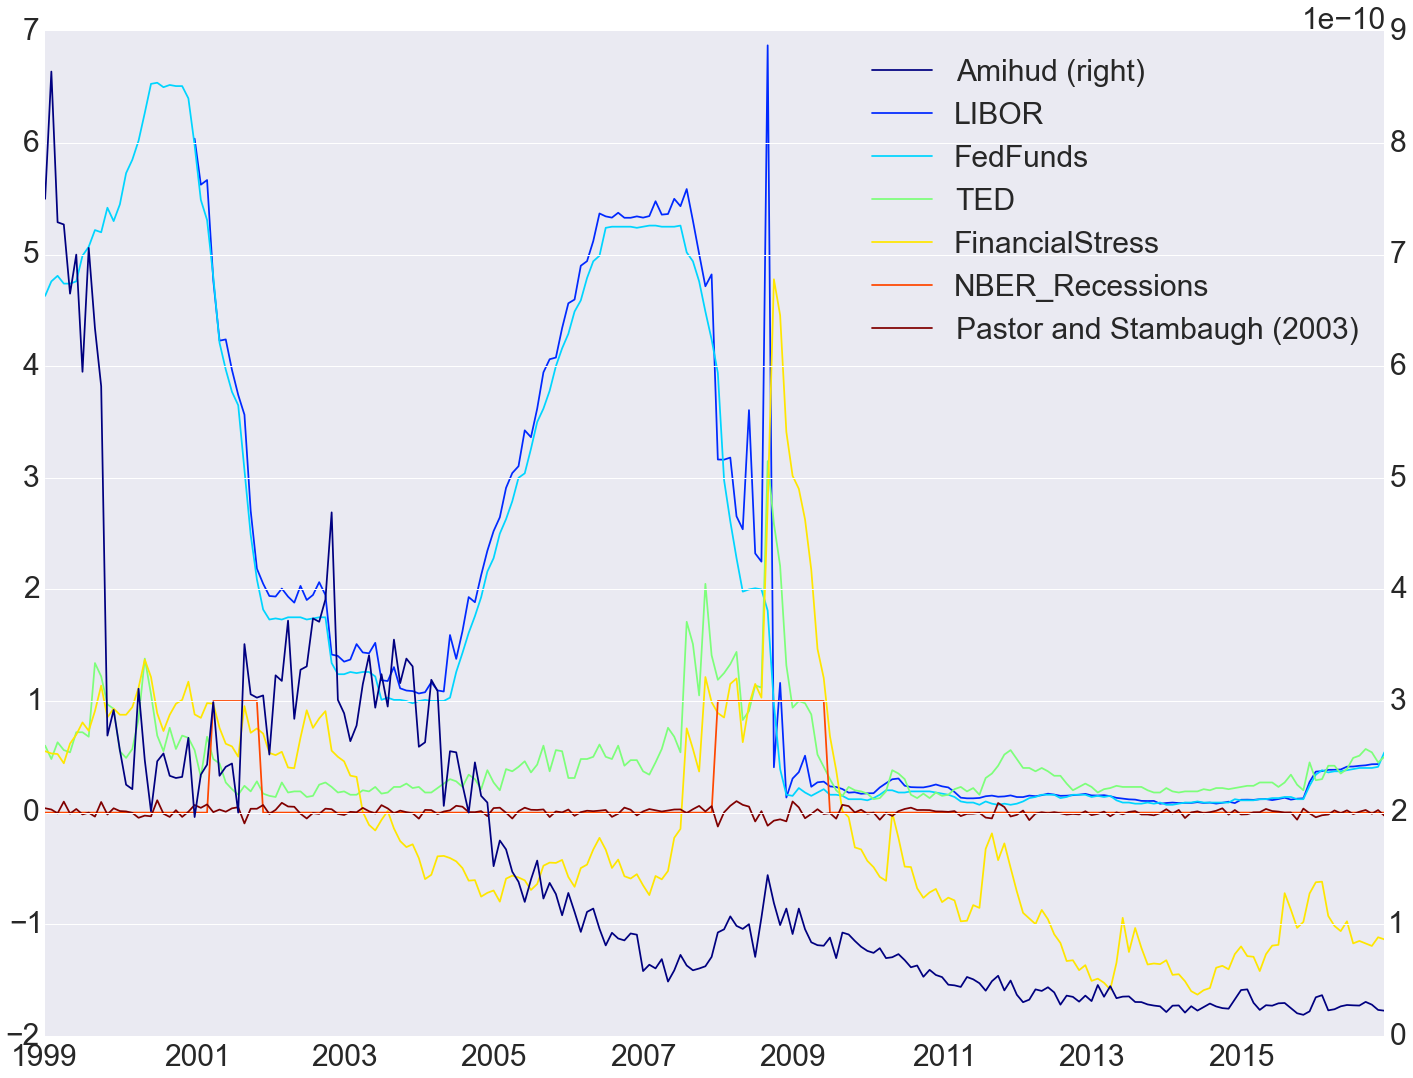

In [27]:
PS=pd.read_csv('PS.csv',parse_dates=[0]).set_index('Month').resample(rule='m',how='last')
factors=pd.read_csv('market_liquidity_factors.csv',index_col=0,parse_dates=[0])
factors['Pastor and Stambaugh (2003)']=PS['Traded liquidity factor']
factors.plot(secondary_y='Amihud',colormap='jet')

In [6]:
central_banks_asset=pd.DataFrame()
central_banks_asset['ECB']=pd.read_csv('ECBASSETS.csv',
                                       parse_dates=['DATE'],
                                       index_col=['DATE']).ECBASSETS.resample(rule='m',how='last')
central_banks_asset['BOJ']=pd.read_csv('JPNASSETS.csv',
                                       parse_dates=['DATE'],
                                       index_col=['DATE']).JPNASSETS.resample(rule='m',how='last') 
central_banks_asset['Fed']=pd.read_csv('WALCL.csv',
                                       parse_dates=['DATE'],
                                       index_col=['DATE']).WALCL.resample(rule='m',how='last')
fx=pd.DataFrame()
fx['BOJ']=quandl.get('CURRFX/USDJPY',authtoken=token).resample(rule='m',how='last').Rate/100
fx['ECB']=quandl.get('CURRFX/USDEUR',authtoken=token).resample(rule='m',how='last').Rate
fx['Fed']=1


/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  after removing the cwd from sys.path.
/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:7: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  import sys
/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:10: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  # Remove the CWD from sys.path while we load stuff.
/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:12: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  if sys.path[0] == '':
/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:13: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  del sys.path[0]


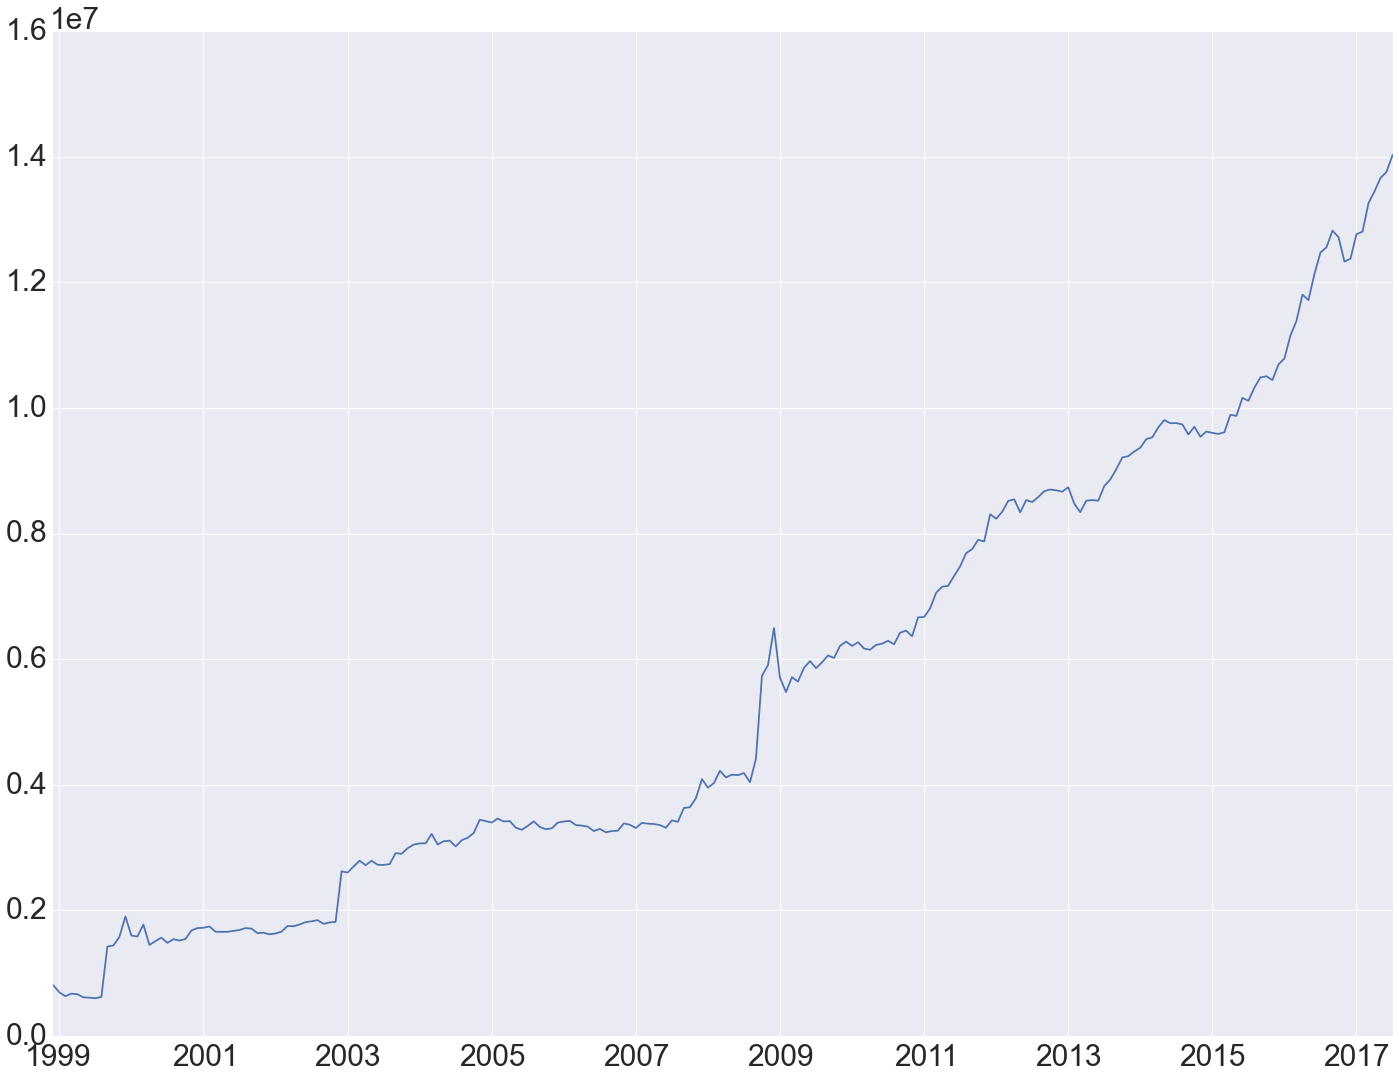

In [28]:
(central_banks_asset/fx).dropna(how='all').sum(axis=1).plot()

In [8]:
factors['Central Bank Assets']=(central_banks_asset/fx).dropna(how='all').sum(axis=1).resample(rule='m',how='last')

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  """Entry point for launching an IPython kernel.


In [9]:
factors['Amihud']=np.log(amihud.median(axis=1).dropna())

I need to understand what the VAR should look like.  Previously I used something that looked like this:

$$ X_t = \mu + \Phi X_{t-1} - \Sigma \varepsilon_t $$

But what is X in this case?

In [10]:
factors.columns

Index([u'Amihud', u'LIBOR', u'FedFunds', u'TED', u'FinancialStress',
       u'NBER_Recessions', u'Pastor and Stambaugh (2003)',
       u'Central Bank Assets'],
      dtype='object')

In [11]:

col=[u'Amihud', u'LIBOR', u'FinancialStress','Central Bank Assets']

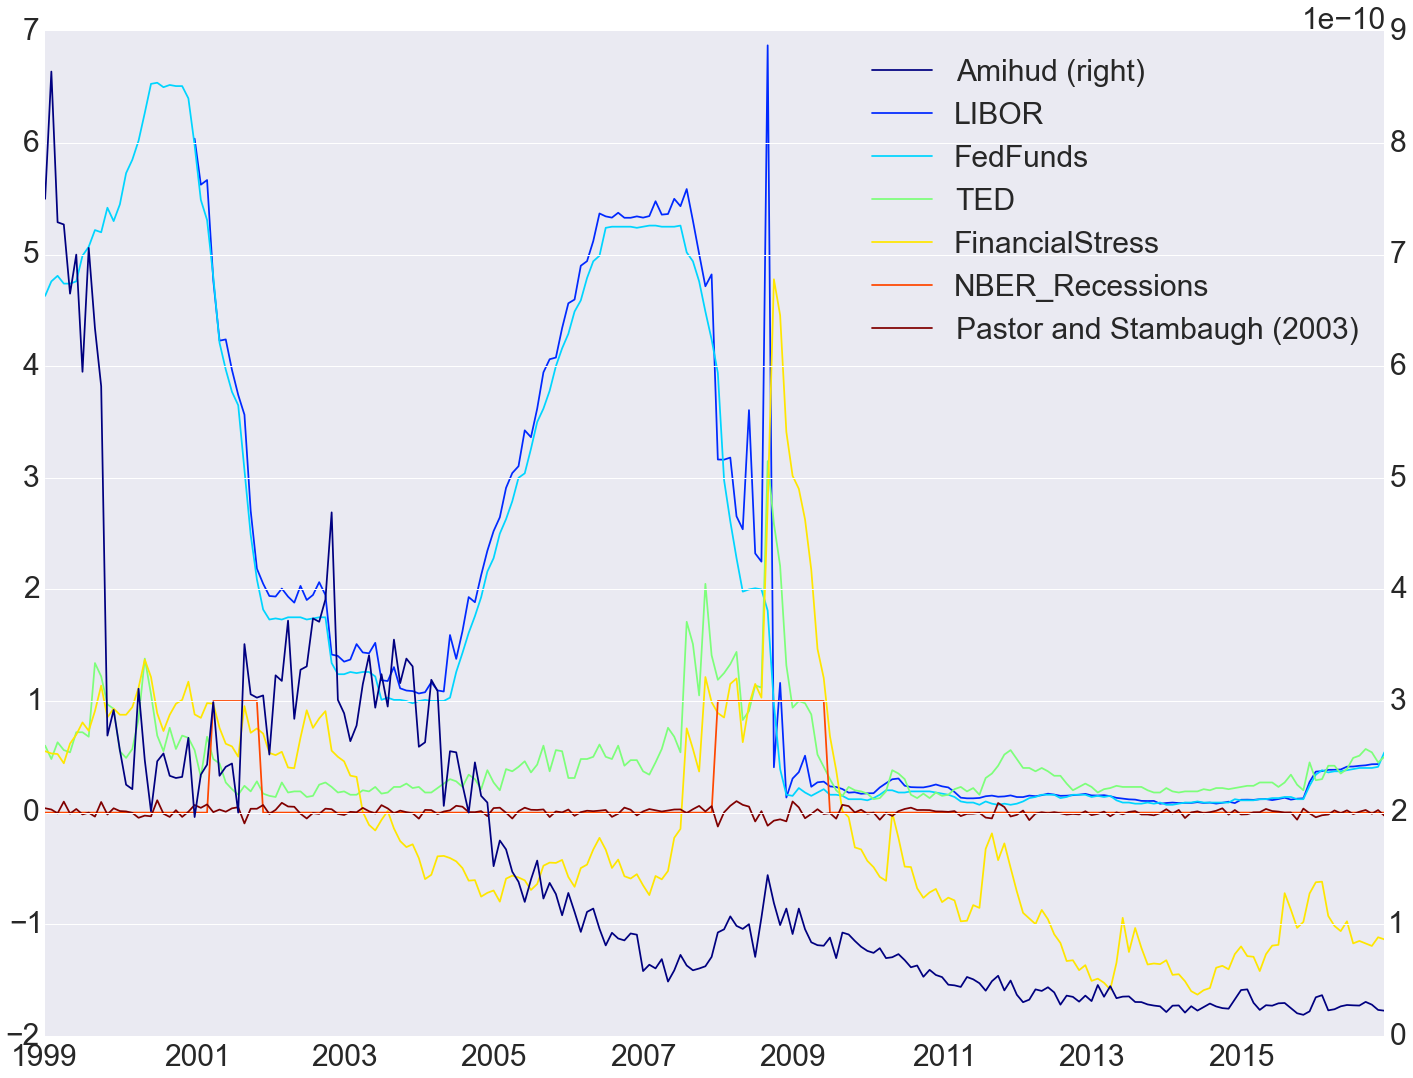

In [29]:
factors.plot(colormap='jet',secondary_y='Amihud')

In [13]:
res = VAR.VAR(endog=factors[col].dropna()).fit()
print res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 27, Jan, 2018
Time:                     11:05:37
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    18.0360
Nobs:                     190.000    HQIC:                   17.8327
Log likelihood:          -2739.34    FPE:                4.83633e+07
AIC:                      17.6942    Det(Omega_mle):     4.35905e+07
--------------------------------------------------------------------
Results for equation Amihud
                            coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------------
const                         -6.048049         1.169429           -5.172           0.000
L1.Amihud                      0.734146         0.051648           14.214           0.000
L1.LIBOR               

In [14]:
df=pd.DataFrame()
df['Values']=res.params.Amihud
df['Tstat']=res.tvalues.Amihud

In [15]:
df

,Values,Tstat
const,-6.048049e+00,-5.171797
L1.Amihud,7.341464e-01,14.214297
L1.LIBOR,-2.975692e-02,-1.922820
L1.FinancialStress,2.668026e-02,1.231613
L1.Central Bank Assets,-7.491907e-08,-4.279568


In [16]:
x=res.params.Amihud

In [17]:
y=pd.DataFrame()
y['Results']=res.params.Amihud.append(res.tvalues.Amihud)

In [18]:
print y.round(2).to_latex()

\begin{tabular}{lr}
\toprule
{} &  Results \\
\midrule
const                  &    -6.05 \\
L1.Amihud              &     0.73 \\
L1.LIBOR               &    -0.03 \\
L1.FinancialStress     &     0.03 \\
L1.Central Bank Assets &    -0.00 \\
const                  &    -5.17 \\
L1.Amihud              &    14.21 \\
L1.LIBOR               &    -1.92 \\
L1.FinancialStress     &     1.23 \\
L1.Central Bank Assets &    -4.28 \\
\bottomrule
\end{tabular}



In [19]:
res = VAR.VAR(endog=factors[col].dropna()).fit(2)
print res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 27, Jan, 2018
Time:                     11:05:37
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    17.3649
Nobs:                     189.000    HQIC:                   16.9976
Log likelihood:          -2619.35    FPE:                1.87696e+07
AIC:                      16.7475    Det(Omega_mle):     1.55827e+07
--------------------------------------------------------------------
Results for equation Amihud
                            coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------------
const                         -4.567153         1.195959           -3.819           0.000
L1.Amihud                      0.476677         0.074450            6.403           0.000
L1.LIBOR               

In [20]:
res = VAR.VAR(endog=factors[col].dropna()).fit(5)
print res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 27, Jan, 2018
Time:                     11:05:37
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    17.8850
Nobs:                     186.000    HQIC:                   17.0186
Log likelihood:          -2499.51    FPE:                1.36888e+07
AIC:                      16.4282    Det(Omega_mle):     8.92352e+06
--------------------------------------------------------------------
Results for equation Amihud
                            coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------------
const                         -2.308666         1.313685           -1.757           0.081
L1.Amihud                      0.320902         0.083378            3.849           0.000
L1.LIBOR               

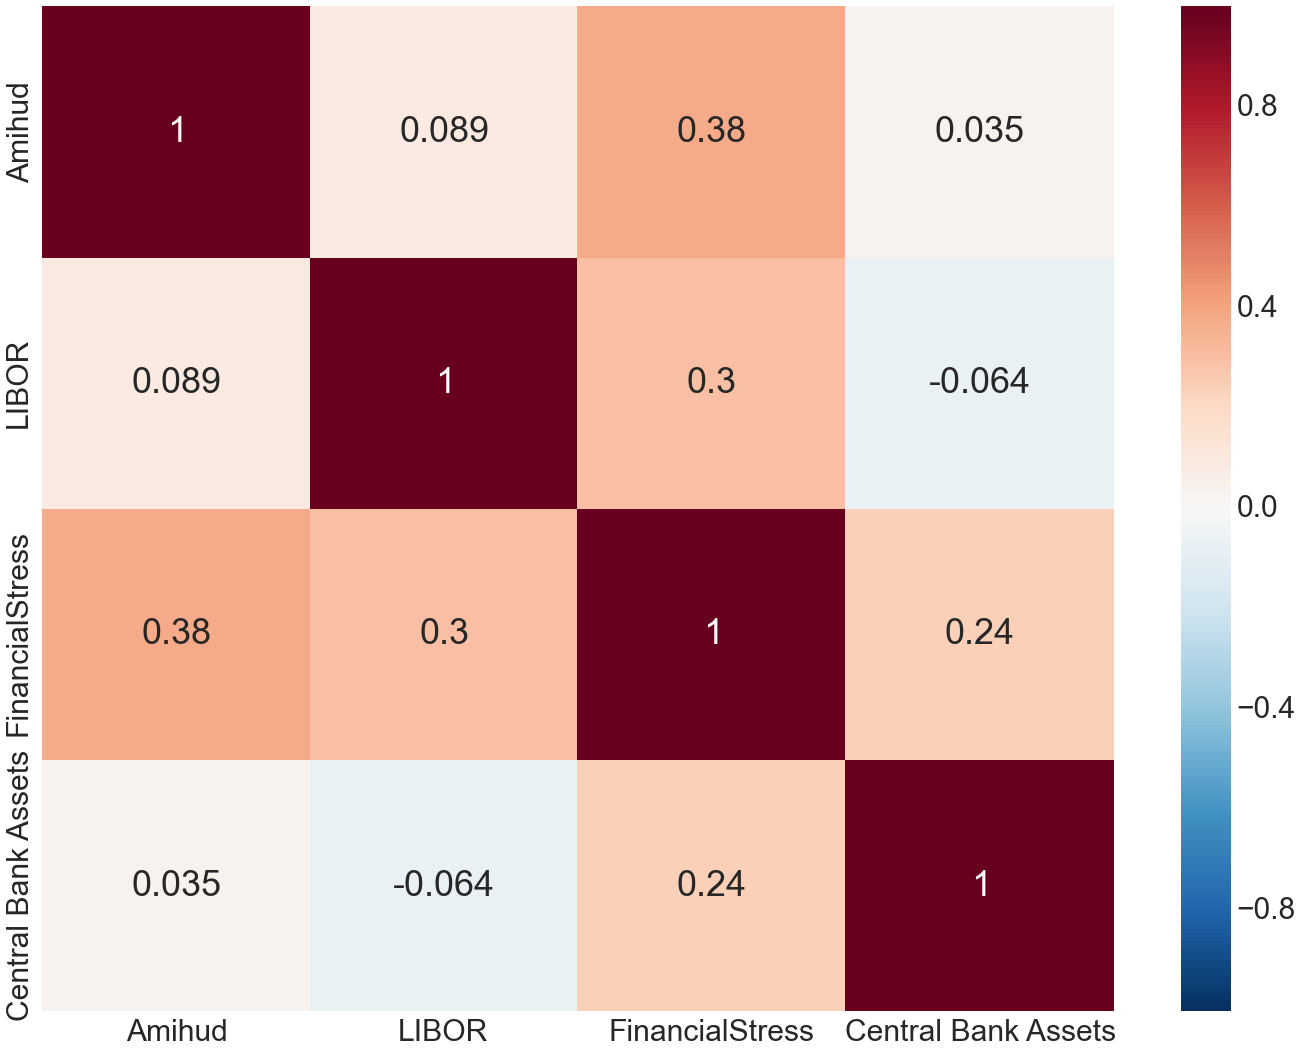

In [30]:
sns.heatmap(pd.DataFrame(res.resid_corr,index=col,columns=col),annot=True)

In [22]:
print pd.DataFrame(res.resid_corr,index=col,columns=col).round(2).to_latex()

\begin{tabular}{lrrrr}
\toprule
{} &  Amihud &  LIBOR &  FinancialStress &  Central Bank Assets \\
\midrule
Amihud              &    1.00 &   0.09 &             0.38 &                 0.04 \\
LIBOR               &    0.09 &   1.00 &             0.30 &                -0.06 \\
FinancialStress     &    0.38 &   0.30 &             1.00 &                 0.24 \\
Central Bank Assets &    0.04 &  -0.06 &             0.24 &                 1.00 \\
\bottomrule
\end{tabular}



In [23]:
model = VAR.VAR(endog=factors[col].dropna())

In [24]:
model.select_order(14)

                 VAR Order Selection                  
            aic          bic          fpe         hqic
------------------------------------------------------
0         28.44        28.51    2.243e+12        28.47
1         17.86        18.22    5.721e+07        18.01
2         16.78       17.43*    1.948e+07        17.05
3         16.57        17.51    1.578e+07       16.95*
4         16.46        17.68    1.413e+07        16.96
5         16.43        17.94    1.373e+07        17.04
6        16.40*        18.20   1.339e+07*        17.13
7         16.48        18.56    1.452e+07        17.32
8         16.54        18.91    1.547e+07        17.50
9         16.45        19.11    1.431e+07        17.53
10        16.49        19.43    1.494e+07        17.68
11        16.46        19.69    1.476e+07        17.77
12        16.45        19.96    1.473e+07        17.87
13        16.47        20.27    1.526e+07        18.01
14        16.51        20.60    1.629e+07        18.17
* Minimum


{'aic': 6, 'bic': 2, 'fpe': 6, 'hqic': 3}

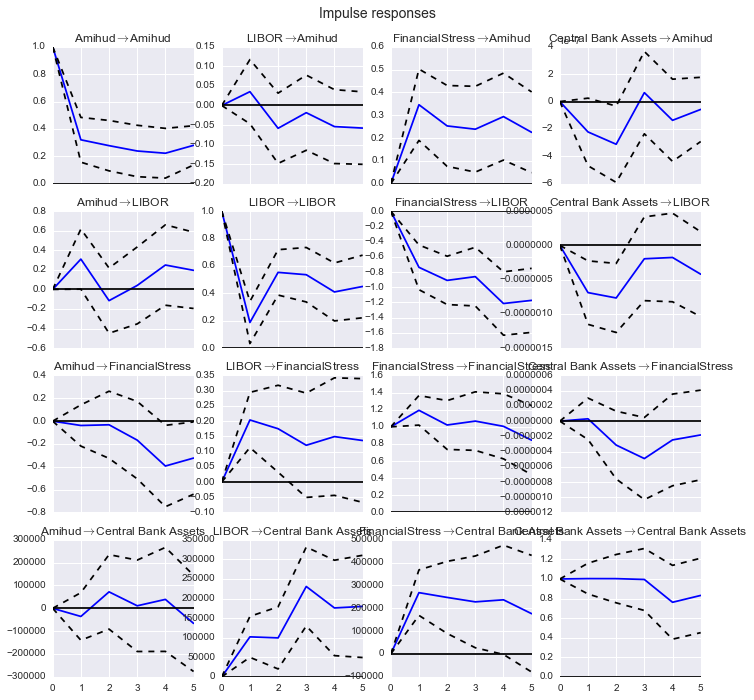

In [25]:
resaic = model.fit(maxlags=5,ic='aic')
irf=resaic.irf(5)
sns.set(font_scale=1)
irf.plot()